# VAEs in 2D
## Part A


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from vae import VAE2D

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np

def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]


def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
        [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

In [10]:
data1 = sample_data_1()
data2 = sample_data_2()

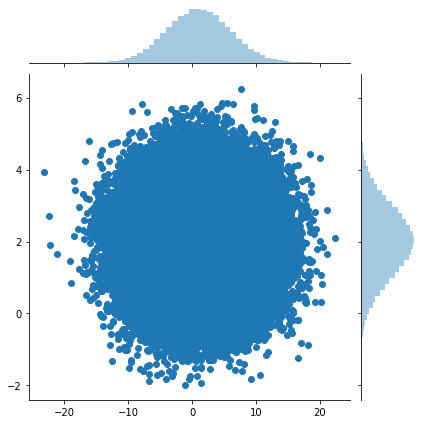

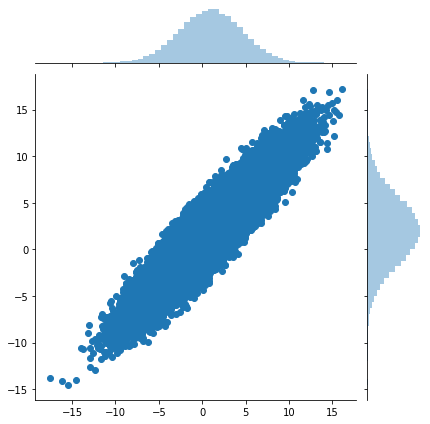

In [11]:
# visualize data
sns.jointplot(data1[:, 0], data1[:, 1])
sns.jointplot(data2[:, 0], data2[:, 1])
train_data1 = TensorDataset(torch.tensor(sample_data_1()))
train_data2 = TensorDataset(torch.tensor(sample_data_2()))

First, investigate both models for dataset 1:


In [12]:
def train(epoch, model, train_loader, opt, log_interval=200, device='cpu'):
    model.train()
    
    loss_history = []
    kl_history = []
    rec_history = []
    for batch_idx, x in enumerate(train_loader):
        opt.zero_grad()
        x = x[0].to(device=device, dtype=torch.float32)
        loss, kl, rec = model(x)
        loss.backward()
        
        opt.step()
        if batch_idx % log_interval == 0:
            loss_history.append(loss.item())
            kl_history.append(kl.item())
            rec_history.append(rec.item())
            print('Loss: ' + str(loss.item()))
    return loss_history, kl_history, rec_history

def validate(model, valid_loader, device='cpu'):
    model.eval()
    
    loss, kl, rec = 0., 0., 0.
    for x in valid_loader:
        x = x[0].to(device=device, dtype=torch.float32)
        with torch.no_grad():
            l, k, r = model(x)
        loss += l.item() * len(x)
        kl += k.item() * len(x)
        rec += r.item() * len(x)
    n_data = len(valid_loader.dataset)
    loss /= n_data; kl /= n_data; rec /= n_data
    return loss, kl, rec

def visualize_samples(num_samples, vae, data):
    with torch.no_grad():
        samples, mu = vae.sample_x(num_samples)
    samples = samples.cpu()
    mu = mu.cpu()
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
    axes[0].scatter(samples[:, 0], samples[:, 1])
    axes[0].scatter(mu[:, 0], mu[:, 1])
    
    axes[1].scatter(data[:, 0], data[:, 1])
    
def plot_loss(loss, kl, rec):
    update_step = np.arange(len(loss))
    # for conversion to bits per dim
    conversion = .5 / np.log(2)
    
    plt.figure(figsize=(10, 7))
    plt.plot(update_step, np.array(loss) * conversion, label='ELBO')
    plt.plot(update_step, np.array(kl) * conversion, label='KL')
    plt.plot(update_step, np.array(rec) * conversion, label='Rec.')
    plt.xlabel('Log step')
    plt.legend()
    
def eval_routine(dataset, vae_type, n_epochs=5, val_dataset=None, device='cuda:0'):
    # training of type A
    train_loader = DataLoader(dataset, batch_size=100, shuffle=True)
    if val_dataset:
        val_loader = DataLoader(val_dataset, batch_size=100)
    vae = VAE2D(dec_type=vae_type)
    opt = torch.optim.Adam(vae.parameters())
    
    vae.to(device)
    loss_history, kl_history, rec_history = [], [], []
    val_loss, val_kl, val_rec = [], [], []
    
    for i in range(n_epochs):
        lh, kh, rh = train(i, vae, train_loader, opt, device=device)
        loss_history.extend(lh)
        kl_history.extend(kh)
        rec_history.extend(rh)
        if val_dataset:
            lv, kv, rv = validate(vae, val_loader, device)
            val_loss.append(lv)
            val_kl.append(kv)
            val_rec.append(rv)
    if val_dataset:
        return vae, (loss_history, kl_history, rec_history), (val_loss, val_kl, val_rec)
    return vae, loss_history, kl_history, rec_history


In [13]:
vae_1A, loss_1A, kl_1A, rec_1A = eval_routine(train_data1, 'A')


Loss: 21.820629119873047
Loss: 4.936811923980713
Loss: 4.5396833419799805
Loss: 4.5503950119018555
Loss: 4.4526824951171875
Loss: 4.526206016540527
Loss: 4.328389644622803
Loss: 4.577937602996826
Loss: 4.415635108947754
Loss: 4.645371437072754
Loss: 4.1759843826293945
Loss: 4.4152374267578125
Loss: 4.489944934844971
Loss: 4.297126293182373
Loss: 4.467661380767822
Loss: 4.372355937957764
Loss: 4.352362632751465
Loss: 4.6485748291015625
Loss: 4.310586929321289
Loss: 4.401391506195068
Loss: 4.412528038024902
Loss: 4.3849053382873535
Loss: 4.652198314666748
Loss: 4.604005813598633
Loss: 4.613924503326416


Visualization of loss and samples:


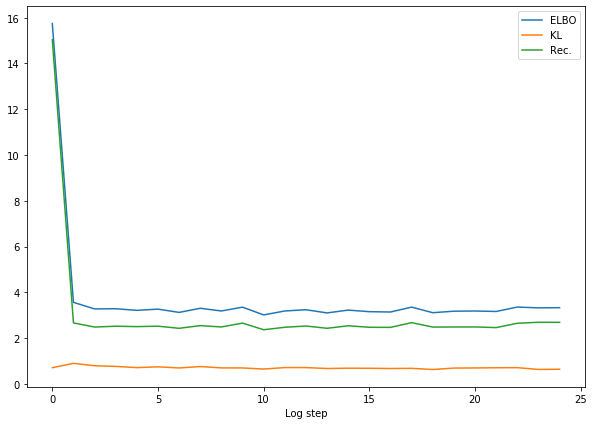

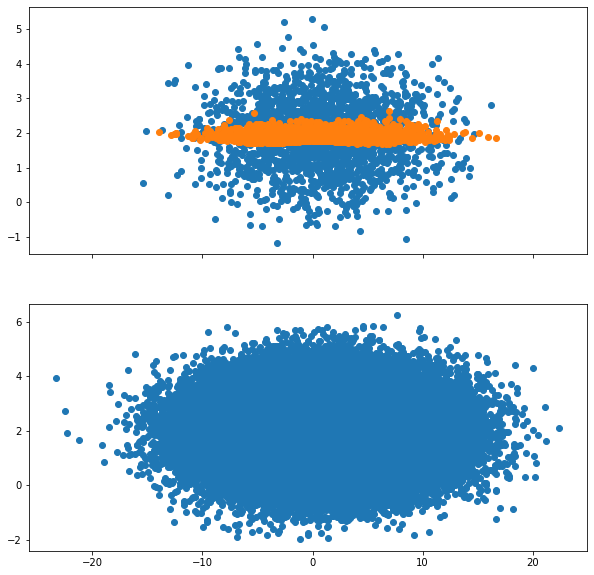

In [15]:
plot_loss(loss_1A, kl_1A, rec_1A)
visualize_samples(2000, vae_1A, data1)


In [16]:
vae_1B, loss_1B, kl_1B, rec_1B = eval_routine(train_data1, 'B')
    

Loss: 55.66260528564453
Loss: 5.387652397155762
Loss: 4.72490119934082
Loss: 5.02363920211792
Loss: 5.118344306945801
Loss: 4.7855544090271
Loss: 4.80606746673584
Loss: 4.851803779602051
Loss: 4.459114074707031
Loss: 4.773631572723389
Loss: 4.946807861328125
Loss: 4.56346321105957
Loss: 4.35854959487915
Loss: 4.331338882446289
Loss: 4.7056660652160645
Loss: 4.493724346160889
Loss: 4.500329971313477
Loss: 4.306180953979492
Loss: 4.5941386222839355
Loss: 4.671361446380615
Loss: 4.612582683563232
Loss: 4.543685436248779
Loss: 4.642587661743164
Loss: 4.2514495849609375
Loss: 4.418214321136475


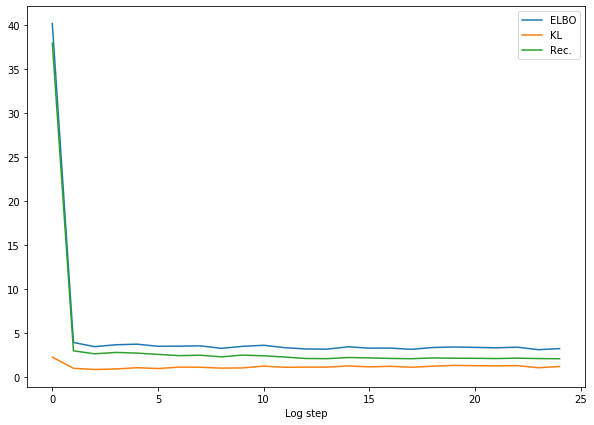

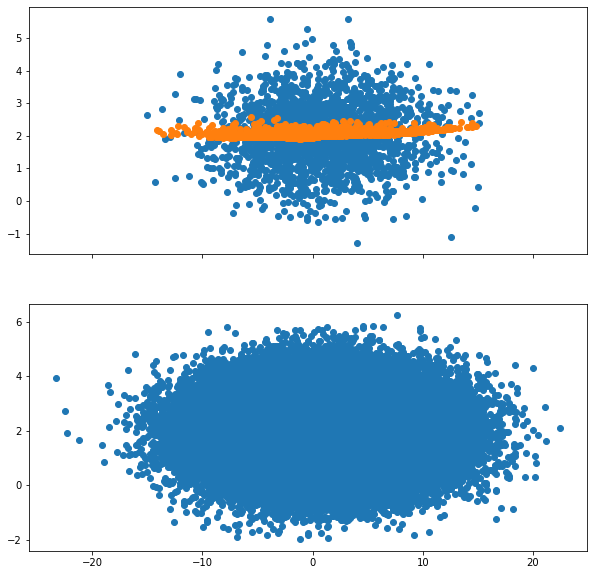

In [17]:
plot_loss(loss_1B, kl_1B, rec_1B)
visualize_samples(2000, vae_1B, data1)


On dataset 2, I get the following results:


In [18]:
vae_2A, loss_2A, kl_2A, rec_2A = eval_routine(train_data2, 'A')
    

Loss: 29.942222595214844
Loss: 5.17832088470459
Loss: 4.978079319000244
Loss: 4.709702491760254
Loss: 4.630721092224121
Loss: 4.3348493576049805
Loss: 4.620065212249756
Loss: 4.472991466522217
Loss: 4.437416076660156
Loss: 4.446315288543701
Loss: 4.233579158782959
Loss: 4.781913757324219
Loss: 4.280881881713867
Loss: 4.519420623779297
Loss: 4.385903835296631
Loss: 4.423735618591309
Loss: 4.398641109466553
Loss: 4.397614479064941
Loss: 4.535150527954102
Loss: 4.502449989318848
Loss: 4.4041266441345215
Loss: 4.598020076751709
Loss: 4.538202285766602
Loss: 4.451106071472168
Loss: 4.569427013397217


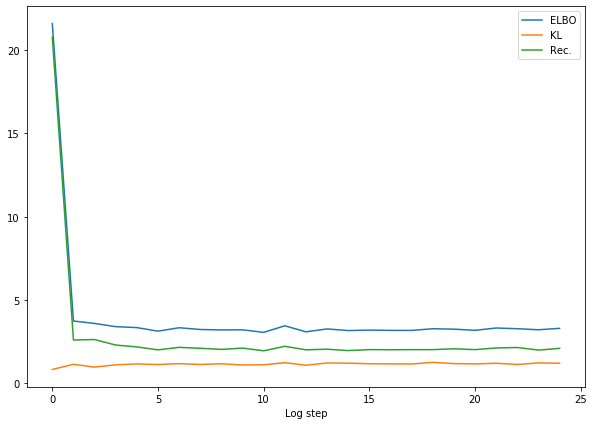

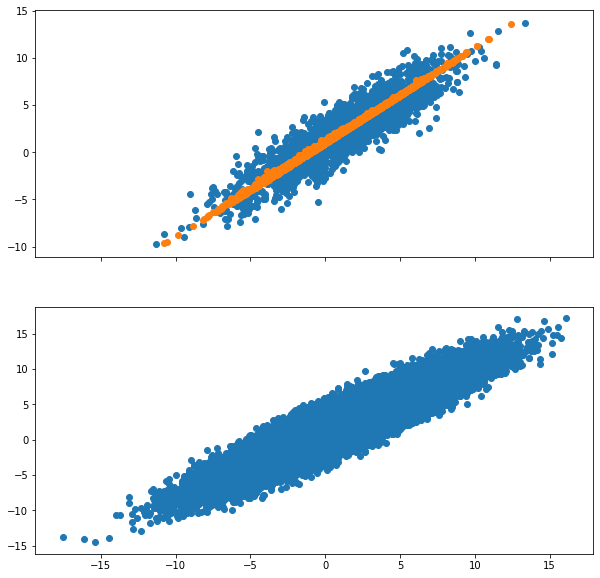

In [19]:
plot_loss(loss_2A, kl_2A, rec_2A)
visualize_samples(2000, vae_2A, data2)


In [20]:
vae_2B, loss_2B, kl_2B, rec_2B = eval_routine(train_data2, 'B')
    

Loss: 23.738651275634766
Loss: 5.3818840980529785
Loss: 4.7789225578308105
Loss: 4.475045204162598
Loss: 4.527570724487305
Loss: 4.614316463470459
Loss: 4.321547985076904
Loss: 4.443367958068848
Loss: 4.350716590881348
Loss: 4.477872371673584
Loss: 4.220763683319092
Loss: 4.552215099334717
Loss: 4.290533542633057
Loss: 4.465148448944092
Loss: 4.6027445793151855
Loss: 4.576985836029053
Loss: 4.486227989196777
Loss: 4.447395324707031
Loss: 4.599328994750977
Loss: 4.155944347381592
Loss: 4.694962024688721
Loss: 4.355164527893066
Loss: 4.425799369812012
Loss: 4.322205066680908
Loss: 4.328184127807617


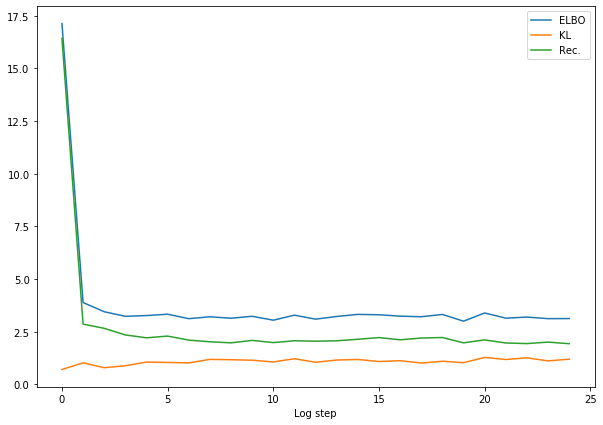

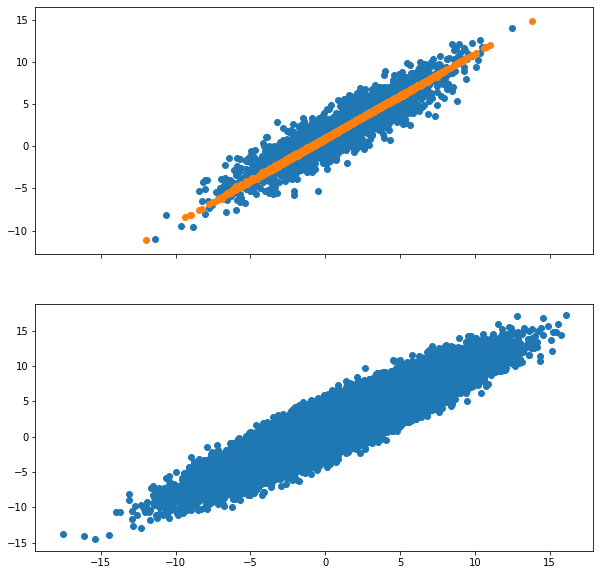

In [21]:
plot_loss(loss_2B, kl_2B, rec_2B)
visualize_samples(2000, vae_2B, data2)


## Part B


In [31]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]
    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

def scatter_plot_with_labels(data, targets):
    x1, x2 = data[:, 0], data[:, 1]
    n_targets = len(np.unique(targets))
    plt.figure()
    for i in range(n_targets):
        mask = torch.tensor(targets == i, dtype=torch.bool)
        plt.scatter(x1[mask], x2[mask], c='C' + str(i), alpha=.1)

/home/m167k/miniconda3/envs/dul_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


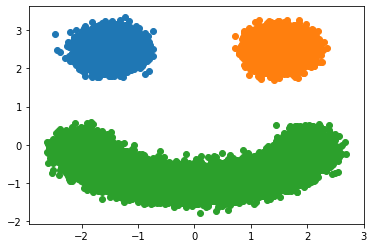

In [23]:
data3, targets3 = sample_data_3()
data3, targets3 = torch.tensor(data3), torch.tensor(targets3)

scatter_plot_with_labels(data3, targets3)


In [24]:
n_train = int(.8 * len(data3))
train_data3, test_data3 = torch.utils.data.random_split(TensorDataset(data3, targets3), (n_train, len(data3) - n_train))
print(len(train_data3), len(test_data3))

79999 20000


In [28]:
vae_3A, (loss_3A, kl_3A, rec_3A), (vloss_3A, vkl_3A, vrec_3A) = \
    eval_routine(train_data3, 'A', val_dataset=test_data3, n_epochs=40)
    

Loss: 5.8015642166137695
Loss: 3.6403985023498535
Loss: 3.6304945945739746
Loss: 3.4121551513671875
Loss: 3.262850284576416
Loss: 2.9558660984039307
Loss: 2.574535369873047
Loss: 2.53043794631958
Loss: 2.527111768722534
Loss: 2.352910041809082
Loss: 2.048462390899658
Loss: 2.1101667881011963
Loss: 2.309847116470337
Loss: 2.403690814971924
Loss: 2.01278018951416
Loss: 2.2881176471710205
Loss: 1.949917197227478
Loss: 2.1651980876922607
Loss: 2.4985289573669434
Loss: 2.061866521835327
Loss: 2.357532024383545
Loss: 2.3067166805267334
Loss: 2.168250799179077
Loss: 2.1035099029541016
Loss: 2.234419584274292
Loss: 2.213047981262207
Loss: 2.092179775238037
Loss: 2.3576087951660156
Loss: 2.127824544906616
Loss: 2.101712226867676
Loss: 2.0505003929138184
Loss: 1.9735761880874634
Loss: 1.7933480739593506
Loss: 1.9897204637527466
Loss: 2.043973684310913
Loss: 1.8172425031661987
Loss: 1.912874460220337
Loss: 1.8373205661773682
Loss: 1.8148812055587769
Loss: 2.168789863586426
Loss: 2.279777288436889

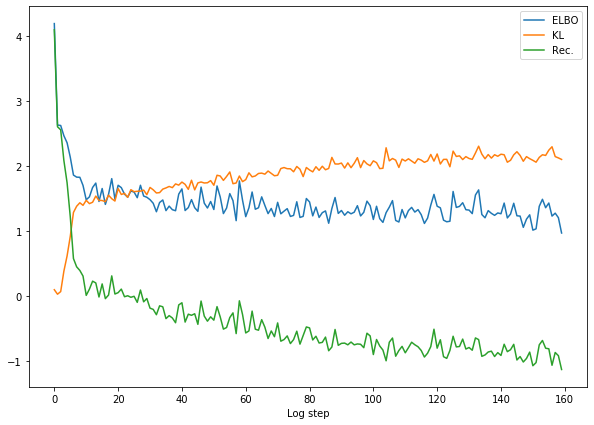

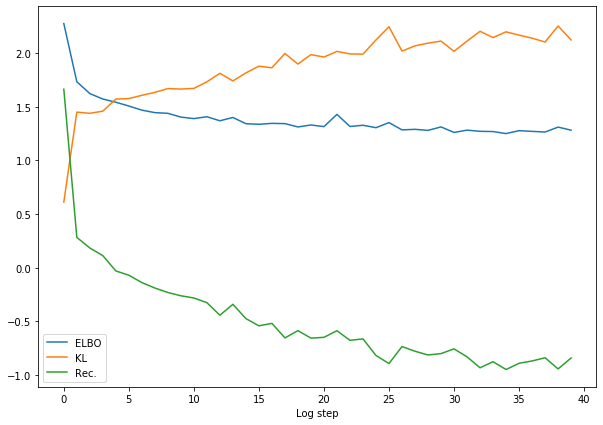

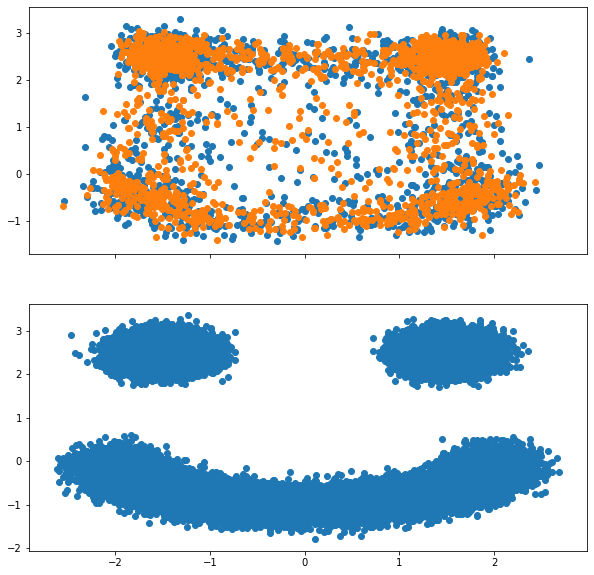

In [29]:
plot_loss(loss_3A, kl_3A, rec_3A)
plot_loss(vloss_3A, vkl_3A, vrec_3A)
visualize_samples(2000, vae_3A, train_data3.dataset.tensors[0])


/home/m167k/miniconda3/envs/dul_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


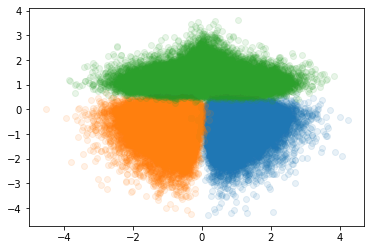

In [32]:
with torch.no_grad():
    x = train_data3.dataset.tensors[0].float().to('cuda:0')
    latent_data = vae_3A.sample_z_from_x(x).cpu()
scatter_plot_with_labels(latent_data, train_data3.dataset.tensors[1])